# Bibliotecas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dataframe dos resultados

In [3]:
path = "/home/lucas/experimentos/MSE_loss_02_pepper_mount_require_grad_test_token_1024/version_1/metrics.csv"

df = pd.read_csv(path)
df

,loss,epoch,step,val_loss
0,0.084907,0,49,NaN
1,0.102523,0,99,NaN
2,0.060947,0,149,NaN
3,0.059175,0,199,NaN
4,0.078691,0,249,NaN
...,...,...,...,...
564,0.037884,26,26949,NaN
565,0.042454,26,26999,NaN
566,0.063571,26,27049,NaN
567,0.074727,26,27099,NaN


# 2. Obtendo a loss de treino e de validacao

## 2.1 Validacao

In [5]:
#df_val_loss = df[df['val_loss'].apply(lambda x: pd.notna(x))].copy()
df_val_loss = df[["epoch","val_loss"]].copy()
df_val_loss.rename({"val_loss":"loss"},inplace=True,axis=1)
df_val_loss["Split"] = "Validação"

df_val_loss = df_val_loss[df_val_loss.loss.apply(lambda x: pd.notna(x))]
df_val_loss

,epoch,loss,Split
20,0,0.064736,Validação
41,1,0.055210,Validação
62,2,0.055254,Validação
83,3,0.056048,Validação
104,4,0.058330,Validação
125,5,0.054294,Validação
146,6,0.054787,Validação
167,7,0.055218,Validação
188,8,0.054035,Validação
209,9,0.066186,Validação


## 2.2 Treino

In [6]:
#index_val = df_val_loss.index.tolist()

#index_val = [x - 1 for x in index_val]
#df_train_loss = df.loc[index_val].copy()
df_train_loss = df[["epoch","loss"]].copy()

df_train_loss["Split"] = "Treino"
df_train_loss

,epoch,loss,Split
0,0,0.084907,Treino
1,0,0.102523,Treino
2,0,0.060947,Treino
3,0,0.059175,Treino
4,0,0.078691,Treino
...,...,...,...
564,26,0.037884,Treino
565,26,0.042454,Treino
566,26,0.063571,Treino
567,26,0.074727,Treino


# 3. Grafico comparativo de Loss

In [7]:
df_concat = pd.concat([df_train_loss,df_val_loss])

<Axes: xlabel='epoch', ylabel='loss'>

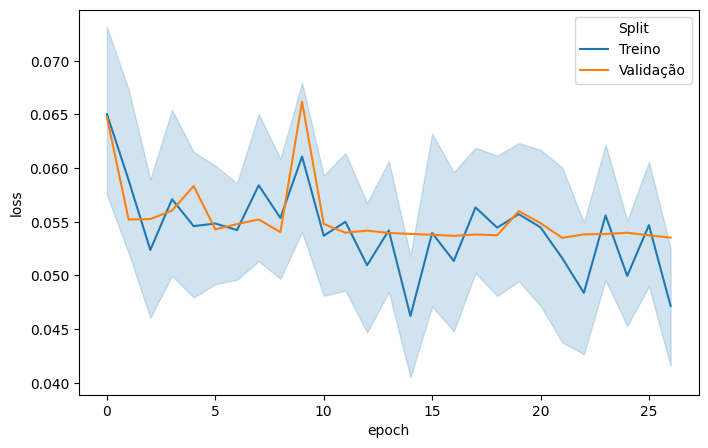

In [8]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=df_concat,x="epoch",y="loss",hue="Split",ax=ax)

#sns.lineplot(data=df,x="epoch",y="loss",ax=ax)
#sns.lineplot(data=df,x="epoch",y="val_loss",ax=ax)

# 4. Load Model

In [9]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
sys.path.append("/home/lucas/Image-Denoising/src")


import pandas as pd
from PIL import Image
from tqdm import tqdm

from model import VisionModel
from noises import add_noise
from dataset import CustomImageDataset

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from utils.light_module import LightningVisionTransformer
from torchvision.transforms import v2

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch import Trainer

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [12]:
class AddNoise(torch.nn.Module):
    def forward(self, img, noise,**kwargs):
        noisy_image = add_noise(img, noise_type=noise,salt_pepper_amount=0.02,**kwargs)

        return Image.fromarray(noisy_image)

batch_size = 2
num_workers = 8
lr = 0.001

noise = AddNoise()
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

path = "/home/lucas/Image-Denoising/dataframes/dataframe_v1.csv"
df = pd.read_csv(path)

val = df[df["split"] == 'val']

val_dataset = CustomImageDataset(val,transform,noise)


custom_dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)



model = VisionModel(
    img_size=(batch_size,3,224,224),
    patch_size=14,
    #patch_size=28,
    #token_len=512,
    token_len=1024,
    embed_dim=1024,
    num_layers=12,
    num_heads=16
)

model = model.cpu()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

model = LightningVisionTransformer.load_from_checkpoint(
    "/home/lucas/experimentos/MSE_loss_02_pepper_mount_require_grad_test_token_1024/version_1/checkpoint-epoch=21-val_loss=0.05.ckpt",
    map_location={"cuda:0":"cpu","cuda:1":"cpu","cuda":"cpu"},
    model=model,
    loss=loss_fn,
    optim=optimizer
)

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# 5 Testando inferencias

In [13]:
i = 0
stop = 2
for ori_img, noi_img in custom_dataloader_val:
    if(i == stop):
        break
    i+=1

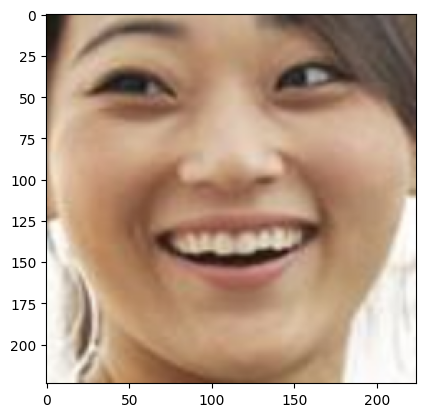

In [14]:
plt.imshow(ori_img[0].permute(1,2,0).detach().numpy())

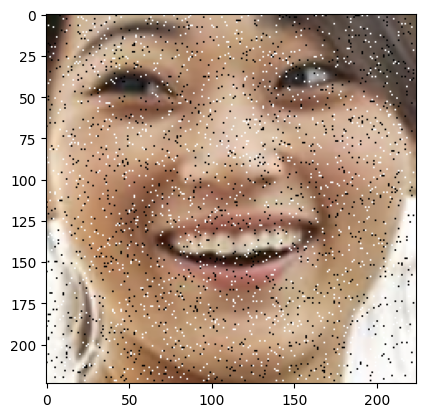

In [15]:
plt.imshow(noi_img[0].permute(1,2,0).detach().numpy())

In [16]:
denoised = model.model(noi_img)

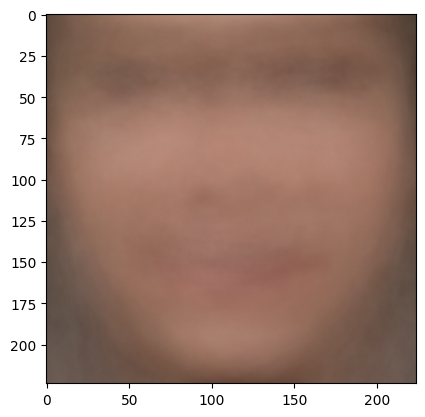

In [17]:
plt.imshow(denoised[0].permute(1,2,0).detach().numpy())